# Final Project EDA

Gaurav Anand (ga7er), Shannon Paylor (sep4hy), Amanda West (acw9gs)

**Questions of Interest:**
1. Number of records ✔️ 
2. Number of columns ✔️ 
3. Statistical summary of response variable ✔️ 
    * Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation. 
4. Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10) ✔️ 
    * Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation. 
6. Include up to five helpful graphs  ✔️ 


## Data

* For our project, we are using [Virginia Court Data](http://virginiacourtdata.org) from a Code for Charlottesville project with the LAJC. 
* For our EDA, we only looked at data from 2019 circuit and district criminal court cases.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
district = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load("district_criminal_2019_anon_00.csv")
circuit  = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load("circuit_criminal_2019.csv")

In [4]:
# most fields are strings, but wanted to create schema so that a few columns are numeric
# set up for districts, but I think circuit is also the same?
fields = []
for f in json.loads(district.schema.json())["fields"]:
    if f["name"] in ['Fine', 'Costs', 'FineCostsDue', 'FineCostsPaid']:
        fields.append(StructField(f["name"], DoubleType(), True))
    else:
        fields.append(StructField.fromJson(f))

schema = StructType(fields)

In [5]:
district = spark.read.schema(schema)\
                .format("csv")\
                .option("header", "true")\
                .load("district_criminal_2019_anon_*.csv")
court = spark.read.schema(schema)\
                .format("csv")\
                .option("header", "true")\
                .load("circuit_criminal_2019.csv")

### 1. Number of records:

In [6]:
circuit.count()

78121

In [7]:
district.count()

76171

### 2. Number of columns:

In [8]:
len(circuit.columns)

50

In [9]:
len(district.columns)

42

### 3. Statistical summary of response variable

We haven't yet decided what we will use as our response variable, as the Code for Charlottesville goals for the project are more focused on descriptive statistics. At the moment, the most probable choice for response variable is `HearingResult`.

Statistical summary of response variable for circuit criminal court in 2019 (both are categorical, so we broke down by count/percentages):

In [10]:
nrows_cir = circuit.count()
hear = circuit.groupBy('HearingResult').agg(F.count(circuit.HearingResult).alias('count'))
hear.withColumn('percent', hear['count']/nrows_cir).show(40)

+--------------------+-----+--------------------+
|       HearingResult|count|             percent|
+--------------------+-----+--------------------+
|Deferred Disposition|   31|3.968203172002406...|
|Not Guilty By Rea...|   17|2.176111416904545...|
|Stet Process Dock...|  223|0.002854546152763...|
|           Continued|    1|1.280065539355615E-5|
|Drug Court, Conti...|    7|8.960458775489305E-5|
|        Carried Over|    7|8.960458775489305E-5|
|             Not Set|  574| 0.00734757619590123|
|        Joint Motion|    2| 2.56013107871123E-5|
|Ordered Into Drug...|   40| 5.12026215742246E-4|
|           True Bill|   73|9.344478437295989E-4|
|Drug Court, Compl...|   40| 5.12026215742246E-4|
|            Remanded|   96|0.001228862917781...|
|Show Cause Dismissed|   41|5.248268711358021E-4|
|No Longer Under A...|  117|0.001497676681046...|
|                null|    0|                 0.0|
|Revoked - Sentenc...|12542| 0.16054581994598124|
| Granted As Modified|   10|1.280065539355615E-4|


Statistical summary of response variable for circuit district court in 2019:

In [11]:
nrows_dis = district.count()
hear = district.groupBy('HearingResult').agg(F.count(district.HearingResult).alias('count'))
hear.withColumn('percent', hear['count']/nrows_dis).show()

+-------------+-----+--------------------+
|HearingResult|count|             percent|
+-------------+-----+--------------------+
|    Finalized|50364|  0.6611965183600058|
|    Continued|    3|3.938506780795841E-5|
|       Waived|25440|  0.3339853750114873|
|         null|    0|                 0.0|
+-------------+-----+--------------------+



**Notes:** As we can see here, it appears that the HearingResult variable is different for district vs. circuit. For district, there are only 4 output options, whereas for circuit the data is much more into the specifics. This is an important finding for us to keep in mind if we choose to using HearingResult as a potential response variable.

### 4. Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)


These may change somewhat, but the likely candidates for predictor variables are:
* `Gender`
* `Race`
* `ChargeType`
* `Class`
* `ProbationType`
* `Fine`
* `Costs`

Statistical summary of potential predictor variables:

#### 4.a) Gender (Categorical)

In [12]:
sex = circuit.groupBy('Sex').agg(F.count(circuit.Sex).alias('count'))
sex.withColumn('percent', sex['count']/nrows_cir).show()

+------+-----+-------------------+
|   Sex|count|            percent|
+------+-----+-------------------+
|  null|    0|                0.0|
|Female|21837|0.27952791182908565|
|  Male|56283| 0.7204592875155208|
+------+-----+-------------------+



In [13]:
sex = district.groupBy('Gender').agg(F.count(district.Gender).alias('count'))
sex.withColumn('percent', sex['count']/nrows_dis).show()

+------+-----+------------------+
|Gender|count|           percent|
+------+-----+------------------+
|  null|    0|               0.0|
|Female|26031|0.3417442333696551|
|  Male|50139|0.6582426382744089|
+------+-----+------------------+



**Note:** sex corresponds to circuit and gender corresponds to district data.

#### 4.b) Race (Categorical)

Circuit:

In [38]:
race = circuit.groupBy('Race').agg(F.count(circuit.Race).alias('count'))
race.withColumn('percent', race['count']/nrows_cir).show(truncate=False)

+----------------------------------------+-----+---------------------+
|Race                                    |count|percent              |
+----------------------------------------+-----+---------------------+
|null                                    |0    |0.0                  |
|Unknown                                 |3    |3.840196618066845E-5 |
|Other (Includes Not Applicable, Unknown)|885  |0.011328580023297194 |
|American Indian Or Alaskan Native       |38   |4.8642490495513373E-4|
|White                                   |43890|0.5618207652231795   |
|Asian Or Pacific Islander               |260  |0.003328170402324599 |
|Black                                   |32401|0.4147540354066128   |
|Hispanic                                |368  |0.0047106411848286634|
+----------------------------------------+-----+---------------------+



District:

In [39]:
district = district.filter(district.Race !='83/55 RECKLESS')\
                   .withColumn('Race', F.regexp_replace('Race', '\(Non-Hispanic\)', ''))\
                   .withColumn('Race', F.regexp_replace('Race', ' Caucasian', ''))

In [40]:
race = district.groupBy('Race').agg(F.count(district.Race).alias('count'))
#condense Black/Black (Non-Hispanic), White/White (Non-Hispanic), etc.
race.withColumn('percent', race['count']/nrows_dis).show(20, False)

+------------------------------------------+-----+---------------------+
|Race                                      |count|percent              |
+------------------------------------------+-----+---------------------+
|Other(Includes Not Applicable, Unknown)   |1183 |0.0155308450722716   |
|American Indian                           |36   |4.7262081369550094E-4|
|White                                     |41697|0.5474130574628139   |
|Asian Or Pacific Islander                 |1123 |0.014743143716112432 |
|Hispanic                                  |2068 |0.02714944007561933  |
|Black                                     |26866|0.35270641057620356  |
|Unknown (Includes Not Applicable, Unknown)|1546 |0.020296438277034565 |
+------------------------------------------+-----+---------------------+



#### 4.c) Charge Type (Categorical)

Circuit:

In [50]:
charge = circuit.groupBy('ChargeType').agg(F.count(circuit.ChargeType).alias('count'))
charge.withColumn('percent', charge['count']/nrows_cir).show(truncate=False)

+---------------------------------------+-----+--------------------+
|ChargeType                             |count|percent             |
+---------------------------------------+-----+--------------------+
|null                                   |0    |0.0                 |
|Infraction                             |1737 |0.02223473841860703 |
|Other (Animal Violations, Bond Appeals)|2994 |0.038325162248307114|
|Civil                                  |359  |0.004595435286286658|
|Felony                                 |55235|0.7070442006630739  |
|Misdemeanor                            |17795|0.2277876627283317  |
+---------------------------------------+-----+--------------------+



District:

In [51]:
charge = district.groupBy('CaseType').agg(F.count(district.CaseType).alias('count'))
charge.withColumn('percent', charge['count']/nrows_dis).show(truncate=False)

+-----------------------------------------------------+-----+---------------------+
|CaseType                                             |count|percent              |
+-----------------------------------------------------+-----+---------------------+
|Capias                                               |1116 |0.014651245224560528 |
|Show Cause                                           |880  |0.0115529532236678   |
|Other                                                |251  |0.00329521733993252  |
|Infraction                                           |52001|0.6826876370272151   |
|Civil Violation                                      |156  |0.0020480235260138375|
|Motion [18.2-271.1(E)]                               |4    |5.2513423743944546E-5|
|Restricted Operator's License For Fine and Costs Only|138  |0.0018117131191660869|
|Felony                                               |3091 |0.04057974819813315  |
|Misdemeanor                                          |16882|0.2216329049113

#### 4.d) Class (Categorical)

In [18]:
classes = circuit.groupBy('Class').agg(F.count(circuit.Class).alias('count'))
classes.withColumn('percent', classes['count']/nrows_cir).show()

+-----+-----+--------------------+
|Class|count|             percent|
+-----+-----+--------------------+
|    3|  801|0.010253324970238476|
| null|    0|                 0.0|
|    5|11228| 0.14372575875884847|
|    U|33117|   0.423919304668399|
|    6| 9762| 0.12495999795189514|
|    O|    1|1.280065539355615E-5|
|    1| 9280| 0.11879008205220107|
|    4| 1387| 0.01775450903086238|
|    2|  946|0.012109420002304118|
+-----+-----+--------------------+



In [53]:
classes = district.groupBy('Class').agg(F.count(district.Class).alias('count'))
classes.withColumn('percent', classes['count']/nrows_dis).show()

+-----+-----+--------------------+
|Class|count|             percent|
+-----+-----+--------------------+
|    3|  278|0.003649682950204146|
| null|    0|                 0.0|
|    5|  956|0.012550708274802747|
|    U| 2012|0.026414252143204107|
|    6|  944|0.012393168003570912|
|    O|  889|0.011671108427091676|
|    C|    1|1.312835593598613...|
|    1| 5257| 0.06901576715547912|
|    4|  990|0.012997072376626275|
|    2|  409| 0.00536949757781833|
+-----+-----+--------------------+



#### 4.e) Probation Type (Categorical)

In [57]:
prob = circuit.groupBy('ProbationType').agg(F.count(circuit.ProbationType).alias('count'))
prob.withColumn('percent', prob['count']/nrows_cir).show(truncate=False)

+----------------------+-----+-------------------+
|ProbationType         |count|percent            |
+----------------------+-----+-------------------+
|null                  |0    |0.0                |
|Unsupervised          |3483 |0.04458468273575607|
|Supervised            |17015|0.2178031515213579 |
|Indefinite Supervision|5986 |0.07662472318582711|
+----------------------+-----+-------------------+



In [56]:
prob = district.groupBy('ProbationType').agg(F.count(district.ProbationType).alias('count'))
prob.withColumn('percent', prob['count']/nrows_dis).show(truncate=False)

+----------------------+-----+--------------------+
|ProbationType         |count|percent             |
+----------------------+-----+--------------------+
|null                  |0    |0.0                 |
|Supervised Probation  |19   |2.494387627837366E-4|
|Unsupervised Probation|406  |0.005330112510010371|
+----------------------+-----+--------------------+



#### 4.f) and 4.g) Fine & Costs (Continuous)

Overall:

In [29]:
fines = district.select(["Fine", "Costs"]).describe()
fines.show()

+-------+-----------------+------------------+
|summary|             Fine|             Costs|
+-------+-----------------+------------------+
|  count|            50178|             57572|
|   mean|86.31523675714455| 78.46845775724312|
| stddev|77.30368826494752|50.050129400102854|
|    min|              0.0|               0.0|
|    max|           2500.0|           1321.23|
+-------+-----------------+------------------+



In [31]:
fines_cir = circuit.select(["FineAmount", "Costs"]).describe()
fines_cir.show()

+-------+------------------+-----------------+
|summary|        FineAmount|            Costs|
+-------+------------------+-----------------+
|  count|             28489|            28783|
|   mean|104.68363929937871|892.8257714623226|
| stddev| 3352.456667889231|2373.465888231958|
|    min|                 0|                0|
|    max|                97|             9997|
+-------+------------------+-----------------+



By racial category:

In [36]:
fines = district.groupBy('Race').agg(F.avg(district.Fine), F.avg(district.Costs))
fines.show(truncate=False)

+------------------------------------------+-----------------+-----------------+
|Race                                      |avg(Fine)        |avg(Costs)       |
+------------------------------------------+-----------------+-----------------+
|Other(Includes Not Applicable, Unknown)   |91.53811149032992|69.50868232890704|
|American Indian                           |77.625           |69.84375         |
|White                                     |83.84573252016263|74.73989649542249|
|Asian Or Pacific Islander                 |86.3281990521327 |71.56690528634361|
|Hispanic                                  |92.91497227356747|66.07516201117319|
|Black                                     |90.46329929802171|87.95178000763481|
|Unknown (Includes Not Applicable, Unknown)|81.01060070671377|71.53420195439739|
+------------------------------------------+-----------------+-----------------+



In [37]:
fines_cir = circuit.groupBy('Race').agg(F.avg(circuit.FineAmount), F.avg(circuit.Costs))
fines_cir.show(truncate=False)

+----------------------------------------+------------------+------------------+
|Race                                    |avg(FineAmount)   |avg(Costs)        |
+----------------------------------------+------------------+------------------+
|null                                    |7.6923076923076925|446.4984615384615 |
|Unknown                                 |0.0               |0.0               |
|Other (Includes Not Applicable, Unknown)|137.74186046511628|1043.8318208092487|
|American Indian Or Alaskan Native       |98.53333333333333 |512.4333333333333 |
|White                                   |133.66357321211345|949.3881723502924 |
|Asian Or Pacific Islander               |56.495049504950494|798.7866336633663 |
|Black                                   |66.37466486839955 |822.1424598628472 |
|Hispanic                                |172.50617283950618|620.5975757575757 |
+----------------------------------------+------------------+------------------+



### 5. Include up to five helpful graphs

First, let's look at fines by racial category:

In [21]:
fines_pd = fines.toPandas()
fines_pd = fines_pd[fines_pd['Race']!='83/55 RECKLESS']

In [22]:
fines_pd = fines_pd[~fines_pd['Race'].isnull()]

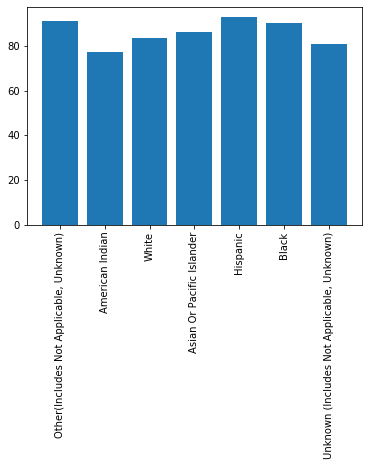

In [23]:
plt.bar(fines_pd['Race'], fines_pd['avg(Fine)'])
plt.xticks(rotation=90)
plt.show()

White people have the lowest average fine of any racial group.

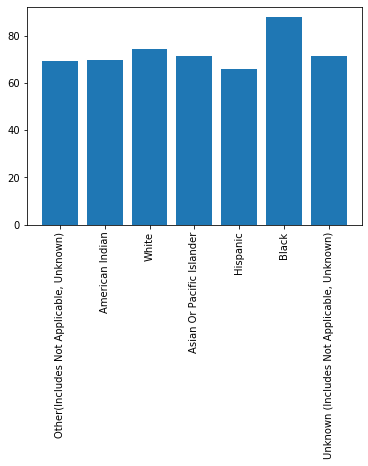

In [24]:
plt.bar(fines_pd['Race'], fines_pd['avg(Costs)'])
plt.xticks(rotation=90)
plt.show()